In [1]:
import sys

sys.path.insert(0, '/gpfs/space/home/dzvenymy/SwinIA-segmentation/')

In [2]:
import os
import cv2
import torch
import einops
import numpy as np
from pathlib import Path
from noise2same.backbone import swinia, unet, unet_b2u
from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
from noise2same import util
from noise2same.dataset.getter import expand_dataset_cfg
from importlib import reload
import seaborn as sns
from matplotlib import pyplot as plt
from typing import Tuple
from noise2same.util import crop_as

In [3]:
util.register_config_resolvers()

In [41]:
swinia = reload(swinia)

In [5]:
path = '/gpfs/space/projects/transformers_uss/'

cfg = OmegaConf.load('../config_seg/config_full_livecell.yaml')
cfg.cwd = Path(os.getcwd())
OmegaConf.resolve(cfg)

expand_dataset_cfg(cfg)
data = instantiate(cfg.dataset_test)

loading annotations into memory...
Done (t=10.08s)
creating index...
index created!


100%|██████████| 1564/1564 [00:35<00:00, 43.94it/s]


In [ ]:
# cf_mice
# path = '/gpfs/space/home/chizhov/noise2same/noise2same.pytorch/results/fmd/swinia/train/2023-11-15_20-23-08_SSFJW/'
# tp_mice
# path = '/gpfs/space/home/chizhov/noise2same/noise2same.pytorch/results/fmd/swinia/train/2023-11-16_15-09-54_NZZIB/'
# cf_fish
# path = '/gpfs/space/home/chizhov/noise2same/noise2same.pytorch/results/fmd/swinia/train/2023-11-16_11-04-57_ZRHCV/'
# synthetic
# path = '/gpfs/space/home/chizhov/noise2same/noise2same.pytorch/results/synthetic/swinia/train/2023-11-17_13-00-36_QJDGV/'

path = '/gpfs/space/projects/transformers_uss/'

cfg = OmegaConf.load('../config_seg/config_full_livecell.yaml')
cfg.cwd = Path(os.getcwd())
OmegaConf.resolve(cfg)
backbone = instantiate(cfg.backbone)
head = instantiate(cfg.head)
denoiser = instantiate(cfg.denoiser, backbone=backbone, head=head)

# expand_dataset_cfg(cfg)
# data = instantiate(cfg.dataset_test)

#checkpoint = torch.load(path + 'checkpoints/model_last.pth')['model']
checkpoint = torch.load(path + 'tp_mice.pth')['model']

denoiser.load_state_dict(checkpoint)
denoiser.to('cuda')

In [43]:
# to get feature map comment line 418 in noise2same/backbone/swinia.py
index = 406
denoiser.eval()
with torch.no_grad():
    result = denoiser(data[index]['image'].unsqueeze(0).cuda())['image'].detach().cpu().numpy()

(<Axes: >, <matplotlib.image.AxesImage at 0x2b6e5afb2140>)

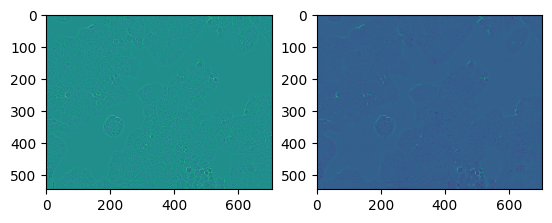

In [40]:
plt.subplot(1,2,1),plt.imshow(vectorized_orig.transpose(1, 2, 0))
plt.subplot(1,2,2), plt.imshow(result.transpose(1, 2, 0))

In [46]:
vectorized_orig = (data[index]['image'] * data[index]['std'] + data[index]['mean']).numpy()
target_shape = data[index]['shape']
target_shape = [144, 520, 704]
# target_shape[-1] = 144

feature_map = crop_as(result[0], target_shape)
vectorized_swinia = feature_map.reshape(-1, 144)
vectorized_heads = np.split(vectorized_swinia, 16, axis=-1)

In [48]:
vectorized_swinia.shape, feature_map.shape

((366080, 144), (144, 520, 704))

<Figure size 1000x1000 with 0 Axes>

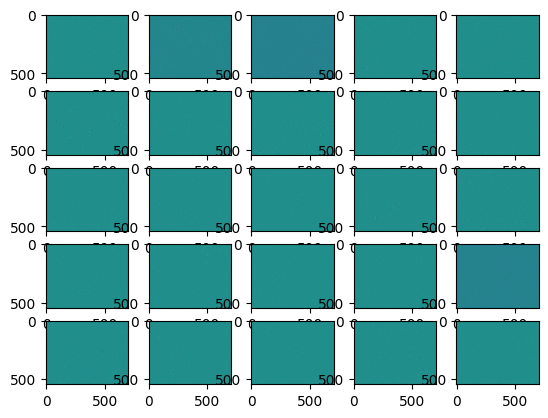

In [19]:
plt.figure(figsize=(10, 10))
fig, axes = plt.subplots(5, 5)
start = 400
for index, ax in zip(range(start, start + 25), axes.flat): 
# image = (data[index]['image'] * data[index]['std'] + data[index]['mean']).numpy()
    ax.imshow(data[index]['image'].permute(1, 2, 0))

In [ ]:
# cf_mice
# path = '/gpfs/space/home/papkov/swinia/results/fmd/unet/train/2023-03-05_23-46-28/'
# tp_mice
# path = '/gpfs/space/home/papkov/swinia/results/fmd/unet/train/2023-03-05_23-52-39/'
# cf_fish
# path = '/gpfs/space/home/papkov/swinia/results/fmd/unet/train/2023-03-05_19-59-25/'
# synthetic
path = '/gpfs/space/home/papkov/swinia/results/synthetic/unet/train/2023-03-04_19-51-14/'

cfg = OmegaConf.load(path + '.hydra/config.yaml')
cfg.cwd = Path(os.getcwd())
OmegaConf.resolve(cfg)
backbone = unet.UNet(in_channels=cfg.data.n_channels, **cfg.backbone)

checkpoint = torch.load(path + 'checkpoints/model_last.pth')['model']
weights = dict()
for key in checkpoint:
    if key.startswith('net.'):
        weights[key.replace('net.', '')] = checkpoint[key]
backbone.load_state_dict(weights)
backbone.to('cuda')
target_shape[-1] = 96

image = (data[index]['image'] * data[index]['std'] + data[index]['mean'])
image = (image - image.mean()) / image.std()
backbone.eval()
with torch.no_grad():
    result = backbone(data[index]['image'].unsqueeze(0).cuda())

feature_map = result.detach().cpu().numpy()
feature_map = crop_as(feature_map.transpose(0, 2, 3, 1)[0], target_shape)
vectorized_n2s = feature_map.reshape(-1, 96)

In [ ]:
# cf_mice
# path = '/gpfs/space/home/chizhov/Blind2Unblind/pretrained_models/Confocal_MICE_112rf20_beta19.7.pth'
# tp_mice
# path = '/gpfs/space/home/chizhov/Blind2Unblind/pretrained_models/TwoPhoton_MICE_112rf20_beta20.pth'
# cf_fish
# path = '/gpfs/space/home/chizhov/Blind2Unblind/pretrained_models/Confocal_FISH_112rf20_beta20.pth'
# synthetic
path = '/gpfs/space/home/chizhov/Blind2Unblind/pretrained_models/g25_112f20_beta19.7.pth'

checkpoint = torch.load(path)
del checkpoint['last.2.weight']
del checkpoint['last.2.bias']
model = unet_b2u.UNetB2UReal(cfg.data.n_channels, cfg.data.n_channels)
model.load_state_dict(checkpoint)
model.to('cuda')
target_shape[-1] = 96

image = (data[index]['image'] * data[index]['std'] + data[index]['mean']) / 255
model.eval()
with torch.no_grad():
    result = model(image.unsqueeze(0).cuda())

feature_map = result.detach().cpu().numpy()
feature_map = crop_as(feature_map.transpose(0, 2, 3, 1)[0], target_shape)
vectorized_b2u = feature_map.reshape(-1, 96)

In [20]:
from sklearn.cluster import KMeans, DBSCAN
from skimage.filters import threshold_otsu

# thresh = threshold_otsu(vectorized_orig[0])
# binary = vectorized_orig > thresh

In [49]:
np.random.seed(111)
k = 2
k_means = KMeans(n_clusters=k)
k_means.fit(vectorized_swinia)
res = k_means.predict(vectorized_swinia)
result_swinia = res.reshape(target_shape[1:])

/gpfs/space/home/dzvenymy/.conda/envs/pt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
res.shape

(366080,)

In [25]:
np.unique(result_swinia)

array([0, 1], dtype=int32)

In [ ]:
k_means = KMeans(n_clusters=k)
k_means.fit(vectorized_n2s)
res = k_means.predict(vectorized_n2s)
result_n2s = res.reshape(target_shape[:2])

In [ ]:
k_means = KMeans(n_clusters=k)
k_means.fit(vectorized_b2u)
res = k_means.predict(vectorized_b2u)
result_b2u = res.reshape(target_shape[:2])

In [ ]:
n2s_0 = np.where(result_n2s == 0)
n2s_1 = np.where(result_n2s == 1)
n2s_2 = np.where(result_n2s == 2)
n2s_3 = np.where(result_n2s == 3)

b2u_0 = np.where(result_b2u == 0)
b2u_1 = np.where(result_b2u == 1)
b2u_2 = np.where(result_b2u == 2)
b2u_3 = np.where(result_b2u == 3)

swin_0 = np.where(result_swinia == 0)
swin_1 = np.where(result_swinia == 1)
swin_2 = np.where(result_swinia == 2)
swin_3 = np.where(result_swinia == 3)

result_n2s_ = result_n2s.copy()
result_n2s_[n2s_0] = 2
result_n2s_[n2s_2] = 0

result_b2u_ = result_b2u.copy()
result_b2u_[b2u_2] = 0
result_b2u_[b2u_1] = 2
result_b2u_[b2u_0] = 1

result_swinia_ = result_swinia.copy()
result_swinia_[swin_2] = 3
result_swinia_[swin_1] = 2
result_swinia_[swin_3] = 1

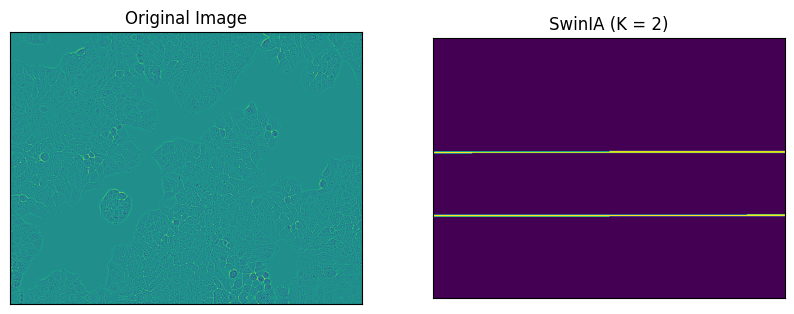

In [52]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 10

figure_size = 10
plt.figure(figsize=(figure_size,figure_size))
#original image
plt.subplot(1,2,1),plt.imshow(vectorized_orig.transpose(1, 2, 0))
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#image 2
# plt.subplot(1,5,2),plt.imshow(binary.transpose(1, 2, 0).astype(int))
# plt.title('Original (Otsu)'), plt.xticks([]), plt.yticks([])
#image 3
# plt.subplot(1,5,3),plt.imshow(result_n2s)
# plt.title('Noise2Same (K = 4)'), plt.xticks([]), plt.yticks([])

# plt.subplot(1,5,4),plt.imshow(result_b2u)
# plt.title('B2U (K = 4)'), plt.xticks([]), plt.yticks([])

plt.subplot(1,2,2),plt.imshow(1-result_swinia)
plt.title('SwinIA (K = 2)'), plt.xticks([]), plt.yticks([]);

In [ ]:
vectorized_orig.shape

In [ ]:
result_b2u.shape

In [ ]:
inertia = []
for k in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    k_means = KMeans(n_clusters=k)
    k_means.fit(vectorized_swinia)
    res = k_means.predict(vectorized_swinia)
    result_swinia = res.reshape(target_shape[:2])
    inertia.append(k_means.inertia_)

In [ ]:
plt.plot([2, 3, 4, 5, 6, 7], inertia)

In [ ]:
(vectorized_orig * data[0]['std'] + data[0]['mean']).shape

In [ ]:
def overlay(
    image: np.ndarray,
    mask: np.ndarray,
    color: Tuple[int, int, int] = (255, 0, 0),
    alpha: float = 0.5, 
    resize: Tuple[int, int] = (1024, 1024)
) -> np.ndarray:
    """Combines image and its segmentation mask into a single image.
    
    Params:
        image: Training image.
        mask: Segmentation mask.
        color: Color for segmentation mask rendering.
        alpha: Segmentation mask's transparency.
        resize: If provided, both image and its mask are resized before blending them together.
    
    Returns:
        image_combined: The combined image.
        
    """
    # if image.ndim == 2:
    #     image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB).transpose(2, 0, 1)
    # if image.ndim == 3 and image.shape[0] == 1:
    #     image = cv2.cvtColor(image[0], cv2.COLOR_GRAY2RGB).transpose(2, 0, 1)
    color = np.asarray(color).reshape(1, 1, 3)
    colored_mask = np.expand_dims(mask, -1).repeat(3, axis=-1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()
    
    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)
    
    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
    
    return image_combined

In [ ]:
vectorized_orig.shape

In [ ]:
plt.rcParams["font.family"] = "times"
plt.rcParams["font.size"] = 20
plt.rcParams['axes.titlepad'] = 12

alpha = 0.6
target_shape[-1] = 3
vectorized_orig_ = vectorized_orig.copy()
# vectorized_orig = crop_as(vectorized_orig.transpose(1, 2, 0), target_shape)

f, ax = plt.subplots(5, 1, figsize=(7, 20))
ax[0].imshow(vectorized_orig / 255, cmap='gray');
# ax[0].set_title('Original image', rotation='vertical',x=-0.1,y=0.1)
# cut_overlay = overlay(vectorized_orig, binary, color=(255, 255, 0), alpha=alpha, resize=None)
# ax[1].imshow(cut_overlay.transpose(1, 2, 0) / 255);
# ax[1].set_title('Original (Otsu)')
cut_overlay = overlay(vectorized_orig, result_n2s, color=(0, 0, 255), alpha=alpha, resize=None)
ax[1].imshow(cut_overlay / 255);
# ax[2].set_title('Noise2Same (k = 2)')
cut_overlay = overlay(vectorized_orig, result_b2u, color=(0, 255, 0), alpha=alpha, resize=None)
ax[2].imshow(cut_overlay / 255);
# ax[3].set_title('Blind2Unblind (k = 2)')
cut_overlay = overlay(vectorized_orig, result_swinia, color=(255, 0, 0), alpha=alpha, resize=None)
ax[3].imshow(cut_overlay / 255);
# ax[4].set_title('SwinIA (k = 2)')
cut_overlay = overlay(vectorized_orig, result_swinia, color=(255, 0, 0), alpha=alpha, resize=None)
cut_overlay = overlay(cut_overlay, result_n2s, color=(0, 255, 0), alpha=alpha, resize=None)
cut_overlay = overlay(cut_overlay, result_b2u, color=(0, 0, 255), alpha=alpha, resize=None)
ax[4].imshow(cut_overlay / 255);
# ax[5].set_title('Overlay')
for a in ax:
    a.axis('off')
plt.tight_layout()
# plt.savefig('seg_tp_mice.png', dpi=200, bbox_inches='tight')

In [ ]:
clusters = []
for head in vectorized_heads:
    k_means = KMeans(n_clusters=2, n_init='auto')
    k_means.fit(head)
    clusters.append(k_means.predict(head))

In [ ]:
kernel = np.array([
    [0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [0, 1, 1, 1, 0]
], dtype=np.uint8)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for cl, ax in zip(clusters, axes.flat):
    # image = cv2.morphologyEx(cl.reshape(512, 512).astype(np.uint8), cv2.MORPH_OPEN, kernel)
    image = cl.reshape(512, 512)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
plt.tight_layout()